In [1]:
TARGET_COL = "nat_demand"
PAST_COVARIATES = [
    "T2M_toc",
    "QV2M_toc",
    "TQL_toc",
    "W2M_toc",
    "T2M_san",
    "QV2M_san",
    "TQL_san",
    "W2M_san",
    "T2M_dav",
    "QV2M_dav",
    "TQL_dav",
    "W2M_dav",
]
KNOWN_COVARIATES = ["holiday", "school"]
seq_length = 128 # 64
pred_length = 24 #32

In [2]:
import pandas as pd
import joblib
from datetime import timedelta

train_df = pd.read_parquet('../../data/panama-electricity-load-forecasting/processed/train.parquet').drop(columns=['Holiday_ID'])
test_df = pd.read_parquet('../../data/panama-electricity-load-forecasting/processed/test.parquet').drop(columns=['Holiday_ID'])

# val_mask = train_df['datetime'] > (train_df['datetime'].max() - timedelta(days=14))
# val_df = train_df[val_mask].reset_index(drop=True)
# train_df = train_df[~val_mask]

# как в AutoGluon с 1 окном
val_df = train_df[-(seq_length + pred_length):].reset_index(drop=True)
train_df = train_df[:-pred_length]

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_length, pred_length, stride=1):
        """
        Датасет для временных рядов с TSMixerExt с возможностью указания шага окна
        
        Args:
            df: pandas DataFrame с временными рядами
            seq_length: длина исторических данных
            pred_length: длина прогноза
            stride: шаг скользящего окна (по умолчанию 1)
        """
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.df = df
        self.stride = stride
        
        total_length = len(df) - seq_length - pred_length + 1
        self.indices = list(range(0, total_length, stride))
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        end_idx = start_idx + self.seq_length + self.pred_length
        
        segment = self.df.iloc[start_idx:end_idx].copy()
        hist_segment = segment.iloc[:self.seq_length]
        future_segment = segment.iloc[self.seq_length:]
        
        x_hist_target = hist_segment[TARGET_COL].values.reshape(-1, 1)
        y_target = future_segment[TARGET_COL].values.reshape(-1, 1)
        
        # x_extra_hist
        x_extra_hist = hist_segment[PAST_COVARIATES].values
        x_extra_hist_known = hist_segment[KNOWN_COVARIATES].values
        
        # x_extra_future
        x_extra_future_past = future_segment[PAST_COVARIATES].values
        x_extra_future_known = future_segment[KNOWN_COVARIATES].values
        
        # x_static
        x_static = np.ones(1)
        
        x_hist = torch.tensor(x_hist_target, dtype=torch.float32)
        x_extra_hist_combined = np.concatenate([x_extra_hist, x_extra_hist_known], axis=1)
        x_extra_hist = torch.tensor(x_extra_hist_combined, dtype=torch.float32)
        
        # torch.tensor
        x_extra_future_combined = np.concatenate([x_extra_future_past, x_extra_future_known], axis=1)
        x_extra_future = torch.tensor(x_extra_future_combined, dtype=torch.float32)
        x_static = torch.tensor(x_static, dtype=torch.float32)
        y = torch.tensor(y_target, dtype=torch.float32)
        
        return {
            "x_hist": x_hist,
            "x_extra_hist": x_extra_hist,
            "x_extra_future": x_extra_future,
            "x_static": x_static,
            "y": y,
        }

In [ ]:
from sklearn.preprocessing import MinMaxScaler

target_columns = 'nat_demand'
column_for_scale = ['T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san',
       'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav']

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))

# train
train_scaled = train_df.copy()

features_scaled = scaler.fit_transform(train_df[column_for_scale])
train_scaled[column_for_scale] = features_scaled

features_scaled = target_scaler.fit_transform(train_df[[target_columns]])
train_scaled[[target_columns]] = features_scaled

# val
val_scaled = val_df.copy()

features_scaled = scaler.transform(val_df[column_for_scale])
val_scaled[column_for_scale] = features_scaled

features_scaled = target_scaler.transform(val_df[[target_columns]])
val_scaled[[target_columns]] = features_scaled

# test
test_scaled = test_df.copy()

features_scaled = scaler.transform(test_df[column_for_scale])
test_scaled[column_for_scale] = features_scaled

features_scaled = target_scaler.transform(test_df[[target_columns]])
test_scaled[[target_columns]] = features_scaled

joblib.dump(scaler, './joblib_artifacts/scaler.joblib')
joblib.dump(target_scaler, './joblib_artifacts/target_scaler.joblib')

['./joblib_artifacts/target_scaler.joblib']

In [29]:
stride = 1

train_dataset = TimeSeriesDataset(train_scaled, seq_length=seq_length, pred_length=pred_length, stride=stride)
val_dataset = TimeSeriesDataset(val_scaled, seq_length=seq_length, pred_length=pred_length, stride=stride)
test_dataset = TimeSeriesDataset(test_scaled, seq_length=seq_length, pred_length=pred_length, stride=1)

In [30]:
def collate_fn(batch):
    x_hist = torch.stack([item["x_hist"] for item in batch])
    x_extra_hist = torch.stack([item["x_extra_hist"] for item in batch])
    x_extra_future = torch.stack([item["x_extra_future"] for item in batch])
    x_static = torch.stack([item["x_static"] for item in batch])
    y = torch.stack([item["y"] for item in batch])
    
    return {
        "x_hist": x_hist,
        "x_extra_hist": x_extra_hist,
        "x_extra_future": x_extra_future,
        "x_static": x_static,
        "y": y,
    }

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

In [7]:
from torchtsmixer import TSMixerExt

input_channels = train_dataset[0]['x_hist'].shape[1]
extra_channels = train_dataset[0]['x_extra_hist'].shape[1]
static_channels = train_dataset[0]['x_static'].shape[0]

model = TSMixerExt(
    sequence_length=seq_length,
    prediction_length=pred_length,
    input_channels=input_channels,
    extra_channels=extra_channels,
    hidden_channels=64,
    static_channels=static_channels,
    output_channels=input_channels,
    normalize_before=False,
    ff_dim=128,
)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn
from tqdm.auto import tqdm
from lion_pytorch import Lion


def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    batch_count = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", leave=False):
            x_hist = batch["x_hist"].to(device)
            x_extra_hist = batch["x_extra_hist"].to(device)
            x_extra_future = batch["x_extra_future"].to(device)
            x_static = batch["x_static"].to(device)
            y = batch["y"].to(device)

            y_pred = model.forward(
                x_hist=x_hist,
                x_extra_hist=x_extra_hist,
                x_extra_future=x_extra_future,
                x_static=x_static,
            )

            loss = criterion(y_pred, y)
            running_loss += loss.item()
            batch_count += 1

    avg_loss = running_loss / batch_count

    return {"loss": avg_loss, "rmse": np.sqrt(avg_loss)}


criterion = nn.MSELoss()
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 100
best_val_loss = float('inf')
epoch_progress = tqdm(range(num_epochs), desc="Epochs", position=0)

model.to(device)
for epoch in epoch_progress:
    model.train()
    running_loss = 0.0
    batch_count = 0

    batch_progress = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", position=1, leave=False
    )

    for batch in batch_progress:
        x_hist = batch["x_hist"].to(device)
        x_extra_hist = batch["x_extra_hist"].to(device)
        x_extra_future = batch["x_extra_future"].to(device)
        x_static = batch["x_static"].to(device)
        y = batch["y"].to(device)

        y_pred = model.forward(
            x_hist=x_hist,
            x_extra_hist=x_extra_hist,
            x_extra_future=x_extra_future,
            x_static=x_static,
        )

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        batch_count += 1

        batch_progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / batch_count
    
    val_metrics = evaluate(model, val_loader, criterion, device)
    
    epoch_progress.set_postfix({
        "train_loss": f"{avg_loss:.4f}",
        "val_loss": f"{val_metrics['loss']:.4f}",
        "val_rmse": f"{val_metrics['rmse']:.4f}"
    })
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_metrics["loss"]:.4f}, Val RMSE: {val_metrics["rmse"]:.4f}')
    
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save(model.state_dict(), 'best_model.pth')
        torch.save(model, 'best_model_full.pth')
        print(f"Model saved with validation loss: {best_val_loss:.4f}")

print("Training complete")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/1362 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [31]:
model = torch.load('best_model_full_5879.pth', weights_only=False)

In [33]:
import pandas as pd
import torch

model.eval()

all_predictions = []
all_true_values = []

with torch.no_grad():
    for i in range(0, len(test_dataset) - pred_length + 1, pred_length):
        sample = test_dataset[i]

        x_hist = sample["x_hist"].unsqueeze(0).to(device)
        x_extra_hist = sample["x_extra_hist"].unsqueeze(0).to(device)
        x_extra_future = sample["x_extra_future"].unsqueeze(0).to(device)
        x_static = sample["x_static"].unsqueeze(0).to(device)
        y = sample["y"].unsqueeze(0).to(device)

        y_pred = model.forward(
            x_hist=x_hist,
            x_extra_hist=x_extra_hist,
            x_extra_future=x_extra_future,
            x_static=x_static,
        )

        y_pred_np = y_pred.cpu().numpy().squeeze()
        y_np = y.cpu().numpy().squeeze()

        all_predictions.append(y_pred_np)
        all_true_values.append(y_np)


all_predictions = np.array(all_predictions).flatten()
all_true_values = np.array(all_true_values).flatten()

all_predictions = target_scaler.inverse_transform(all_predictions.reshape(-1, 1)).flatten()
all_true_values = target_scaler.inverse_transform(all_true_values.reshape(-1, 1)).flatten()
# all_true_values = test_df['nat_demand'].values

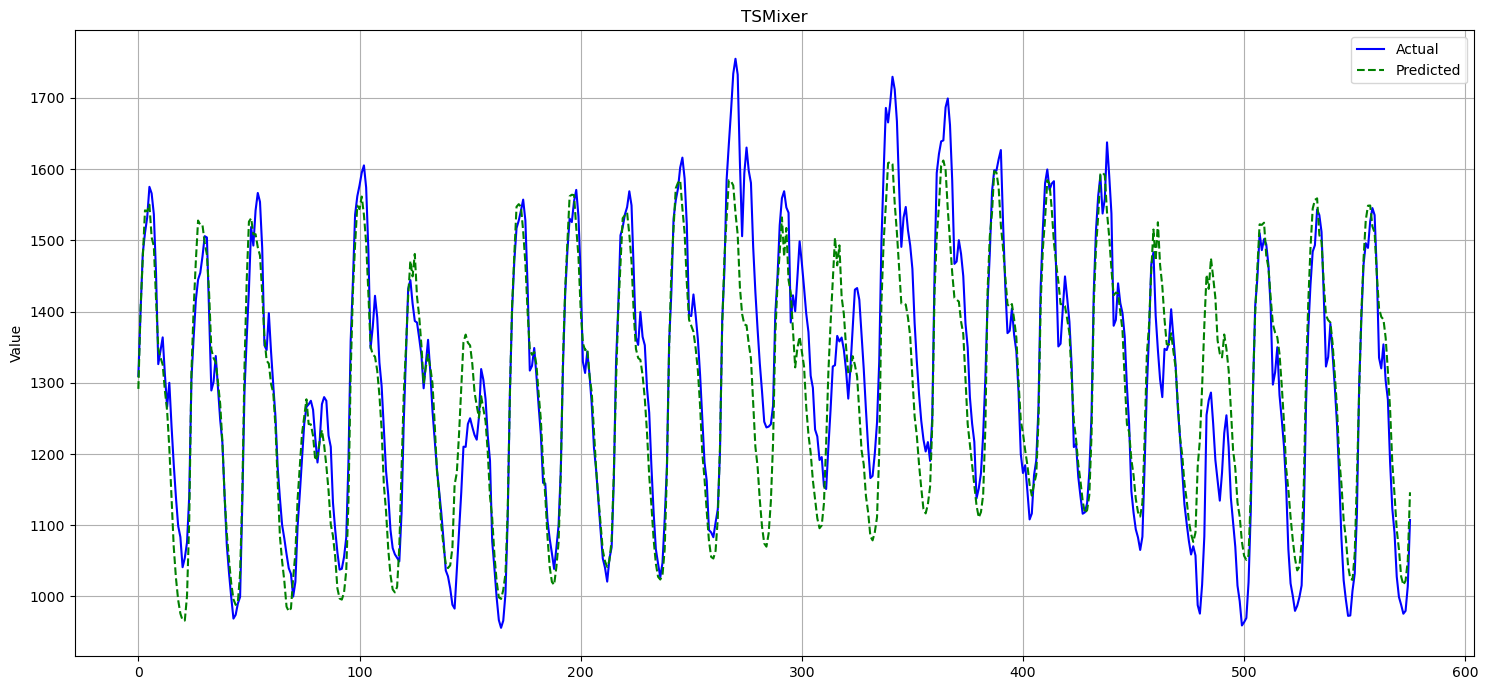

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(all_true_values, 'b-', label='Actual')
plt.plot(all_predictions, 'g--', label='Predicted')

plt.ylabel('Value')
plt.title('TSMixer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predictions.png')
plt.show()

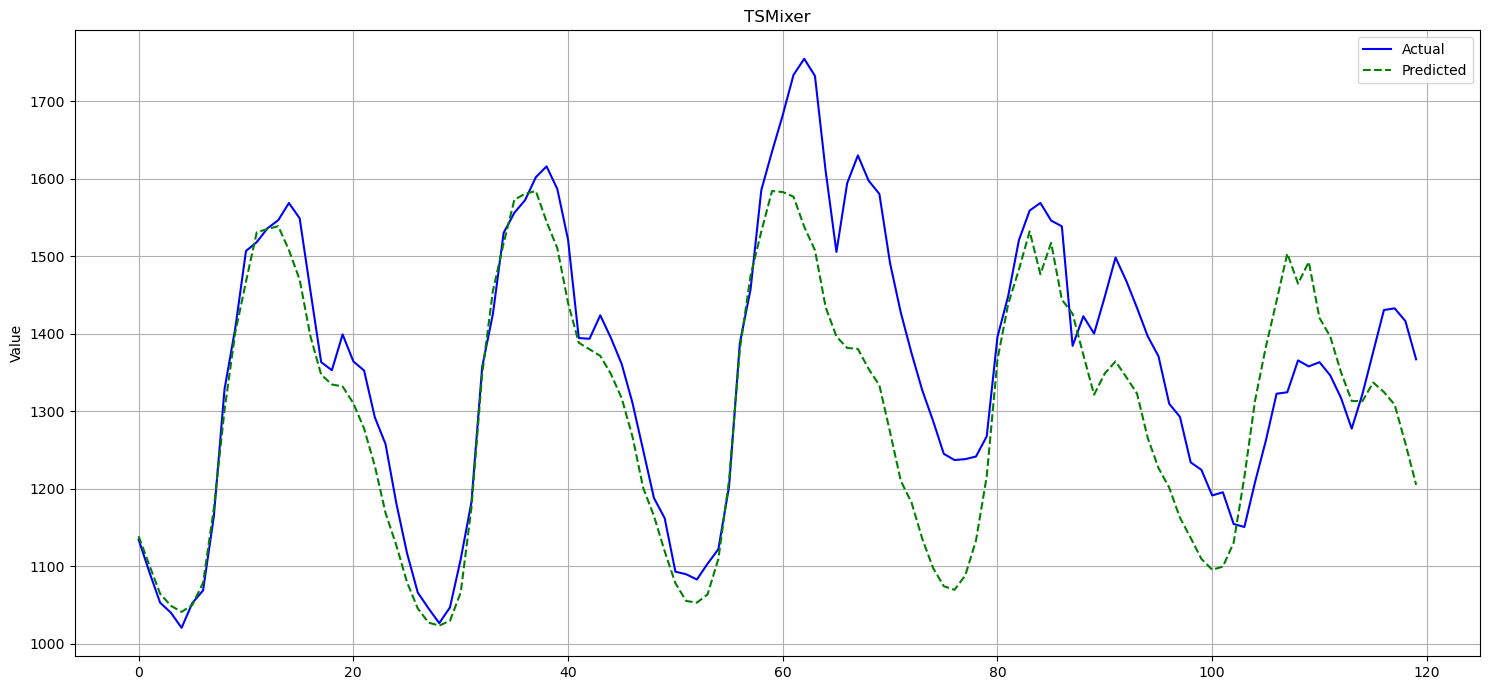

In [35]:
date_mask = (test_df['datetime'] >= '2020-01-15') & (test_df['datetime'] < '2020-01-20')
slice_start = max(0, np.where(date_mask)[0][0] - seq_length)
slice_end = slice_start + date_mask.sum()

plt.figure(figsize=(15, 7))

plt.plot(all_true_values[slice_start:slice_end], 'b-', label='Actual')
plt.plot(all_predictions[slice_start:slice_end], 'g--', label='Predicted')

plt.ylabel('Value')
plt.title('TSMixer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predictions.png')
plt.show()

In [ ]:
from sklearn import metrics as sk_m

sk_m.mean_squared_error(y_true=all_true_values, y_pred=all_predictions)

6761.742